# Installing Packages

In [2]:
!pip install astropy escnn pytorch_msssim
!pip install gdown --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 86.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
  Created wheel for py3nj: filename=py3nj-0.2.1-cp310-cp310-linux_x86_64.whl size=44801 sha256=6674a2800bcae92520dad23bc3a3c7a09723dbf1719aaa3995a9d1e09adac80e
  Stored in directory: /root/.cache/pip/wheels/71/e9/70/30a34ed6dbc8b54ce93f25c091be4cf7a24319e27d953a882b
Successfully built py3nj


# Importing Packages

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt


from astropy.io import fits
from tqdm.auto import tqdm
import glob
import sys
import zipfile


from sklearn.cluster import KMeans, SpectralClustering
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold


from escnn import gspaces, nn as enn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_msssim import ms_ssim

# Downloading Data and Models

In [4]:
file_id = "15tQuOqEWjS2GBQO5SOuGE7M6UHyGDg63"
!gdown --id $file_id

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=15tQuOqEWjS2GBQO5SOuGE7M6UHyGDg63
From (redirected): https://drive.google.com/uc?id=15tQuOqEWjS2GBQO5SOuGE7M6UHyGDg63&confirm=t&uuid=c48ff247-6d23-4593-becc-cf10364edac0
To: /kaggle/working/EXXA-models&data-20250401T060641Z-001.zip
100%|█████████████████████████████████████████| 658M/658M [00:03<00:00, 195MB/s]


In [5]:
# EXTRACTING DOWNLOADED FILE
base_path = '/kaggle/working'
extract_dir = base_path


zip_filepath = base_path+'/EXXA-models&data-20250401T060641Z-001.zip'
with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


zip_filepath = base_path+'/EXXA-models&data/continuum_data_subset-20250303T002205Z-001.zip'
with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    zip_ref.extractall(base_path)


# Preparing Dataloader

In [6]:
image_dir_path = base_path+"/continuum_data_subset"
paths = sorted(glob.glob(image_dir_path+"/*.fits"))

len(paths)

150

In [7]:
mean = 0.0
var = 0.0
for path in paths:
    with fits.open(path) as hdul:
            image = hdul[0].data[0][0][0]
    mean += np.mean(image)
    var += (np.std(image))**2

mean /= len(paths)
var /= len(paths)
std = np.sqrt(var)
print(mean,std)

1.586220816712411e-22 4.667396082087401e-22


In [8]:
def normalise(image):
    if std == 0:
        return image - mean
    normalized_img = (image - mean) / (std)
    return normalized_img

class MeraDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        with fits.open(self.paths[idx]) as hdul:
            image = hdul[0].data[0][0][0]
        image = normalise(image)
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32)
        return image

In [9]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=3, sigma=(2, 3)),
    transforms.Pad(padding=414, padding_mode="edge"),
    transforms.RandomChoice([
        transforms.RandomAffine(degrees=180,shear=(20, 50)),
        transforms.RandomAffine(degrees=180,shear=(-50, -20)),
        transforms.RandomAffine(degrees=180,scale=(0.6,1))
    ]),
    # transforms.RandomRotation(degrees=90),
    transforms.CenterCrop((600, 600)),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.4, contrast=0.8)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

In [10]:
full_train_dataset = MeraDataset(paths, transform=train_transforms)
full_train_dataloader = DataLoader(full_train_dataset, batch_size=16, shuffle=True)

# Model Architecture

In [11]:
class EquivariantAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=16, num_rotations=8, dropout_prob=0.0):
        super(EquivariantAE, self).__init__()

        self.gspace = gspaces.flipRot2dOnR2(N=num_rotations)
        self.input_type = enn.FieldType(self.gspace, in_channels * [self.gspace.trivial_repr])

        self.conv1 = enn.R2Conv(self.input_type,
                                enn.FieldType(self.gspace, 4 * [self.gspace.regular_repr]),
                                kernel_size=3, stride=2, padding=1)
        self.relu1 = enn.ELU(self.conv1.out_type, inplace=True)

        self.conv2 = enn.R2Conv(self.conv1.out_type,
                                enn.FieldType(self.gspace, 8 * [self.gspace.regular_repr]),
                                kernel_size=3, stride=2, padding=1)
        self.relu2 = enn.ELU(self.conv2.out_type, inplace=True)

        self.conv3 = enn.R2Conv(self.conv2.out_type,
                                enn.FieldType(self.gspace, latent_dim * [self.gspace.regular_repr]),
                                kernel_size=3, stride=2, padding=1)
        self.relu3 = enn.ELU(self.conv3.out_type, inplace=True)
        self.group_pool = enn.GroupPooling(self.conv3.out_type)

        self.deconv1 = enn.R2ConvTransposed(self.conv3.out_type,
                                            self.conv2.out_type,
                                            kernel_size=3, stride=2, padding=1, output_padding=1)
        self.drop1 = enn.FieldDropout(self.deconv1.out_type, p=dropout_prob)
        self.relu4 = enn.ELU(self.deconv1.out_type, inplace=True)

        self.deconv2 = enn.R2ConvTransposed(self.deconv1.out_type,
                                            self.conv1.out_type,
                                            kernel_size=3, stride=2, padding=1, output_padding=1)
        self.drop2 = enn.FieldDropout(self.deconv2.out_type, p=dropout_prob)
        self.relu5 = enn.ELU(self.deconv2.out_type, inplace=True)

        self.deconv3 = enn.R2ConvTransposed(self.deconv2.out_type,
                                            enn.FieldType(self.gspace, in_channels * [self.gspace.trivial_repr]),
                                            kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        x = enn.GeometricTensor(x, self.input_type)
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        return x

    def project(self, z):
        z = self.group_pool(z)
        z = z.tensor.mean(dim=[2, 3], keepdim=True)
        z = F.normalize(z, dim=1)
        return z.squeeze()

    def decode(self, x):
        x = self.relu4(self.drop1(self.deconv1(x)))
        x = self.relu5(self.drop2(self.deconv2(x)))
        x = self.deconv3(x)
        return x.tensor

    def forward(self, x):
        encoded = self.encode(x)
        projected = self.project(encoded)
        decoded = self.decode(encoded)
        return decoded, projected

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Training

In [12]:

def resnet18_feature_extractor():
    model = models.resnet18(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-2])
    for param in model.parameters():
        param.requires_grad = False
    return model

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.feature_extractor = resnet18_feature_extractor()
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x = x.repeat(1, 3, 1, 1)
        features_x = self.feature_extractor(x)
        y = y.repeat(1, 3, 1, 1)
        features_y = self.feature_extractor(y)
        loss = self.criterion(features_x, features_y)
        return loss

def orthogonality_loss(z):
    batch_size, dim = z.shape
    z = z - z.mean(dim=0, keepdim=True)
    cov_matrix = (z.T @ z) / (batch_size - 1)
    identity = torch.eye(dim, device=z.device)
    loss = torch.norm(cov_matrix * (1 - identity), p="fro")
    return loss

perceptual_loss = PerceptualLoss().to(device)

def focal_loss(preds, targets, alpha=1e-7, gamma=2.0):
    mse=perceptual_loss(preds, targets)
    focal_loss = (alpha+mse)**(gamma)
    return focal_loss.mean()

def focal_mse_loss(x_recon, x, gamma=2.0):
    mse = (x_recon - x) ** 2
    weights = torch.exp(-gamma * x.abs())
    return (weights * mse).mean()

# def simclr_loss(z1, z2, temperature=0.5):

#     z1 = F.normalize(z1, p=2, dim=1)
#     z2 = F.normalize(z2, p=2, dim=1)
#     z = torch.cat([z1, z2], dim=0)
#     sim_matrix = torch.mm(z, z.T)
#     batch_size = z1.shape[0]
#     mask = torch.eye(2 * batch_size, device=z.device).bool()
#     sim_matrix = sim_matrix.masked_fill(mask, float('-inf'))
#     positives = torch.cat([torch.diag(sim_matrix, batch_size), torch.diag(sim_matrix, -batch_size)], dim=0)
#     loss = -torch.log(torch.exp(positives / temperature) / torch.sum(torch.exp(sim_matrix / temperature), dim=1))
#     return loss.mean()

# simclr_aug = transforms.Compose([
#     transforms.Pad(padding=414, padding_mode="edge"),
#     transforms.RandomChoice([
#         transforms.RandomAffine(degrees=180,scale=(0.6,1),shear=(20, 50)),
#         transforms.RandomAffine(degrees=180,scale=(0.6,1),shear=(-50, -20))
#     ]),
#     transforms.CenterCrop((256, 256)),
# ])

loss_history = []

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


In [13]:
eae = EquivariantAE().to(device)
optimizer = torch.optim.Adam(eae.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.66, patience=2, verbose=True)
num_epochs = 100
loss_history = {"avg_train_loss":[] ,"recon_loss":[] }
best_train_loss = 1e7
best_model = None

In [15]:

eae.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    perceptual = 0.0
    reconstruct = 0.0
    ortho = 0.0
    msssim_train_total = 0.0
    
    train_loader_tqdm = tqdm(full_train_dataloader, desc=f"Training", leave=False)
    for x in train_loader_tqdm:
        x = x.to(device)
        x_recon, z1 = eae(x)

        recon_loss = focal_mse_loss(x_recon, x)
        perceptional = focal_loss(x_recon, x)
        mutli_ssim = ms_ssim(x_recon, x, data_range=1.0, size_average=True)
        loss = 0.7*orthogonality_loss(z1) + recon_loss + 3 * perceptional
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        perceptual += perceptional.item()
        ortho += orthogonality_loss(z1).item()
        reconstruct += recon_loss.item()
        epoch_loss += loss.item()
        msssim_train_total += mutli_ssim.item()

    scheduler.step(epoch_loss)
    avg_train_loss = epoch_loss / len(full_train_dataloader)
    avg_msssim_train = msssim_train_total / len(full_train_dataloader)
    loss_history["avg_train_loss"].append(avg_train_loss)
    loss_history["recon_loss"].append(reconstruct/len(full_train_dataloader))
    # loss_history["msssim_loss"].append(msssim_train_total)

    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        least_mssim = avg_msssim_train/len(full_train_dataloader)
        least_recons = reconstruct/len(full_train_dataloader)
        eae.eval()
        best_model = {
            'model_state_dict': eae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss_history': loss_history
        }
        eae.train()
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.3f}, "
               f"Ortho: {ortho/len(full_train_dataloader):.3f}, "
               f"Perceptual: {perceptual/len(full_train_dataloader):.3f}, "
               f"MSE: {reconstruct/len(full_train_dataloader):.3f}")
    

model_path = f"eae_light.pth"
eae.eval()
torch.save(best_model, model_path)
print("\n", f"Saved best model with Train loss: {best_train_loss:.4f} , MSE: {least_recons:.4f} , MSSSIM: {msssim_train_total/len(full_train_dataloader):.4f} at {model_path}")
torch.cuda.empty_cache()

print("\n========== Training Completed ==========\n")


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.683, Ortho: 0.043, Perceptual: 0.870, MSE: 0.043


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 2.371, Ortho: 0.021, Perceptual: 0.764, MSE: 0.065


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 1.986, Ortho: 0.027, Perceptual: 0.628, MSE: 0.084


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 1.800, Ortho: 0.022, Perceptual: 0.570, MSE: 0.074


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 1.823, Ortho: 0.027, Perceptual: 0.579, MSE: 0.066


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 1.658, Ortho: 0.021, Perceptual: 0.538, MSE: 0.029


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 1.608, Ortho: 0.020, Perceptual: 0.516, MSE: 0.045


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 1.545, Ortho: 0.012, Perceptual: 0.505, MSE: 0.023


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 1.299, Ortho: 0.024, Perceptual: 0.420, MSE: 0.023


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 1.351, Ortho: 0.022, Perceptual: 0.435, MSE: 0.032


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 1.394, Ortho: 0.023, Perceptual: 0.449, MSE: 0.032


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 1.256, Ortho: 0.024, Perceptual: 0.404, MSE: 0.028


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 1.253, Ortho: 0.021, Perceptual: 0.399, MSE: 0.041


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 1.313, Ortho: 0.020, Perceptual: 0.421, MSE: 0.036


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 1.225, Ortho: 0.023, Perceptual: 0.394, MSE: 0.028


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 1.256, Ortho: 0.017, Perceptual: 0.405, MSE: 0.029


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 1.178, Ortho: 0.014, Perceptual: 0.382, MSE: 0.023


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 1.237, Ortho: 0.013, Perceptual: 0.402, MSE: 0.022


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 1.093, Ortho: 0.019, Perceptual: 0.348, MSE: 0.036


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 1.210, Ortho: 0.011, Perceptual: 0.394, MSE: 0.020


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 1.112, Ortho: 0.010, Perceptual: 0.359, MSE: 0.028


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.949, Ortho: 0.014, Perceptual: 0.302, MSE: 0.032


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 1.037, Ortho: 0.012, Perceptual: 0.337, MSE: 0.018


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 1.055, Ortho: 0.010, Perceptual: 0.344, MSE: 0.016


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.969, Ortho: 0.011, Perceptual: 0.314, MSE: 0.020


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.922, Ortho: 0.009, Perceptual: 0.300, MSE: 0.018


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.962, Ortho: 0.011, Perceptual: 0.313, MSE: 0.014


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.901, Ortho: 0.011, Perceptual: 0.293, MSE: 0.014


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.949, Ortho: 0.007, Perceptual: 0.311, MSE: 0.011


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.974, Ortho: 0.012, Perceptual: 0.317, MSE: 0.014


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.871, Ortho: 0.021, Perceptual: 0.281, MSE: 0.015


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.884, Ortho: 0.012, Perceptual: 0.288, MSE: 0.012


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 1.042, Ortho: 0.020, Perceptual: 0.336, MSE: 0.021


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 1.019, Ortho: 0.006, Perceptual: 0.335, MSE: 0.008


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.996, Ortho: 0.009, Perceptual: 0.325, MSE: 0.016


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.891, Ortho: 0.010, Perceptual: 0.290, MSE: 0.015


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.804, Ortho: 0.011, Perceptual: 0.259, MSE: 0.020


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.868, Ortho: 0.008, Perceptual: 0.282, MSE: 0.018


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.742, Ortho: 0.008, Perceptual: 0.241, MSE: 0.013


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.833, Ortho: 0.008, Perceptual: 0.271, MSE: 0.015


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.785, Ortho: 0.007, Perceptual: 0.256, MSE: 0.013


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.796, Ortho: 0.007, Perceptual: 0.260, MSE: 0.011


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.801, Ortho: 0.010, Perceptual: 0.261, MSE: 0.013


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.739, Ortho: 0.006, Perceptual: 0.242, MSE: 0.009


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.783, Ortho: 0.006, Perceptual: 0.257, MSE: 0.009


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.799, Ortho: 0.005, Perceptual: 0.262, MSE: 0.010


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.818, Ortho: 0.007, Perceptual: 0.269, MSE: 0.008


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.694, Ortho: 0.006, Perceptual: 0.228, MSE: 0.007


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.756, Ortho: 0.007, Perceptual: 0.247, MSE: 0.008


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.681, Ortho: 0.005, Perceptual: 0.223, MSE: 0.008


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.655, Ortho: 0.005, Perceptual: 0.214, MSE: 0.008


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.755, Ortho: 0.005, Perceptual: 0.247, MSE: 0.011


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.789, Ortho: 0.005, Perceptual: 0.260, MSE: 0.006


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.686, Ortho: 0.005, Perceptual: 0.225, MSE: 0.007


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.672, Ortho: 0.004, Perceptual: 0.220, MSE: 0.008


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.670, Ortho: 0.004, Perceptual: 0.220, MSE: 0.007


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.664, Ortho: 0.004, Perceptual: 0.218, MSE: 0.008


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.657, Ortho: 0.004, Perceptual: 0.216, MSE: 0.007


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.774, Ortho: 0.004, Perceptual: 0.255, MSE: 0.006


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.662, Ortho: 0.004, Perceptual: 0.217, MSE: 0.008


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.688, Ortho: 0.004, Perceptual: 0.226, MSE: 0.006


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.680, Ortho: 0.004, Perceptual: 0.224, MSE: 0.006


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.665, Ortho: 0.004, Perceptual: 0.219, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [64/100], Train Loss: 0.743, Ortho: 0.004, Perceptual: 0.245, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [65/100], Train Loss: 0.642, Ortho: 0.004, Perceptual: 0.212, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [66/100], Train Loss: 0.725, Ortho: 0.004, Perceptual: 0.238, MSE: 0.008


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [67/100], Train Loss: 0.669, Ortho: 0.004, Perceptual: 0.221, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [68/100], Train Loss: 0.652, Ortho: 0.004, Perceptual: 0.215, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [69/100], Train Loss: 0.679, Ortho: 0.004, Perceptual: 0.224, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [70/100], Train Loss: 0.671, Ortho: 0.004, Perceptual: 0.221, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [71/100], Train Loss: 0.725, Ortho: 0.004, Perceptual: 0.239, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [72/100], Train Loss: 0.679, Ortho: 0.004, Perceptual: 0.224, MSE: 0.006


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [73/100], Train Loss: 0.622, Ortho: 0.004, Perceptual: 0.205, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [74/100], Train Loss: 0.619, Ortho: 0.004, Perceptual: 0.204, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [75/100], Train Loss: 0.744, Ortho: 0.004, Perceptual: 0.245, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [76/100], Train Loss: 0.700, Ortho: 0.003, Perceptual: 0.231, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [77/100], Train Loss: 0.625, Ortho: 0.003, Perceptual: 0.205, MSE: 0.007


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [78/100], Train Loss: 0.626, Ortho: 0.004, Perceptual: 0.206, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [79/100], Train Loss: 0.727, Ortho: 0.003, Perceptual: 0.240, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [80/100], Train Loss: 0.668, Ortho: 0.004, Perceptual: 0.220, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [81/100], Train Loss: 0.667, Ortho: 0.003, Perceptual: 0.220, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [82/100], Train Loss: 0.611, Ortho: 0.003, Perceptual: 0.201, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [83/100], Train Loss: 0.743, Ortho: 0.003, Perceptual: 0.245, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [84/100], Train Loss: 0.701, Ortho: 0.004, Perceptual: 0.231, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [85/100], Train Loss: 0.665, Ortho: 0.003, Perceptual: 0.219, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [86/100], Train Loss: 0.673, Ortho: 0.004, Perceptual: 0.222, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [87/100], Train Loss: 0.619, Ortho: 0.004, Perceptual: 0.204, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [88/100], Train Loss: 0.641, Ortho: 0.004, Perceptual: 0.211, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [89/100], Train Loss: 0.677, Ortho: 0.004, Perceptual: 0.223, MSE: 0.006


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [90/100], Train Loss: 0.588, Ortho: 0.003, Perceptual: 0.194, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [91/100], Train Loss: 0.646, Ortho: 0.003, Perceptual: 0.213, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [92/100], Train Loss: 0.647, Ortho: 0.003, Perceptual: 0.214, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [93/100], Train Loss: 0.689, Ortho: 0.004, Perceptual: 0.227, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [94/100], Train Loss: 0.595, Ortho: 0.004, Perceptual: 0.196, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [95/100], Train Loss: 0.607, Ortho: 0.004, Perceptual: 0.200, MSE: 0.005


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [96/100], Train Loss: 0.659, Ortho: 0.003, Perceptual: 0.217, MSE: 0.006


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [97/100], Train Loss: 0.636, Ortho: 0.003, Perceptual: 0.210, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [98/100], Train Loss: 0.633, Ortho: 0.004, Perceptual: 0.208, MSE: 0.006


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [99/100], Train Loss: 0.646, Ortho: 0.004, Perceptual: 0.213, MSE: 0.004


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [100/100], Train Loss: 0.604, Ortho: 0.004, Perceptual: 0.199, MSE: 0.005

 Saved best model with Train loss: 0.5879 , MSE: 0.0040 , MSSSIM: 0.9519 at eae_light.pth

========== Training Completed ==========



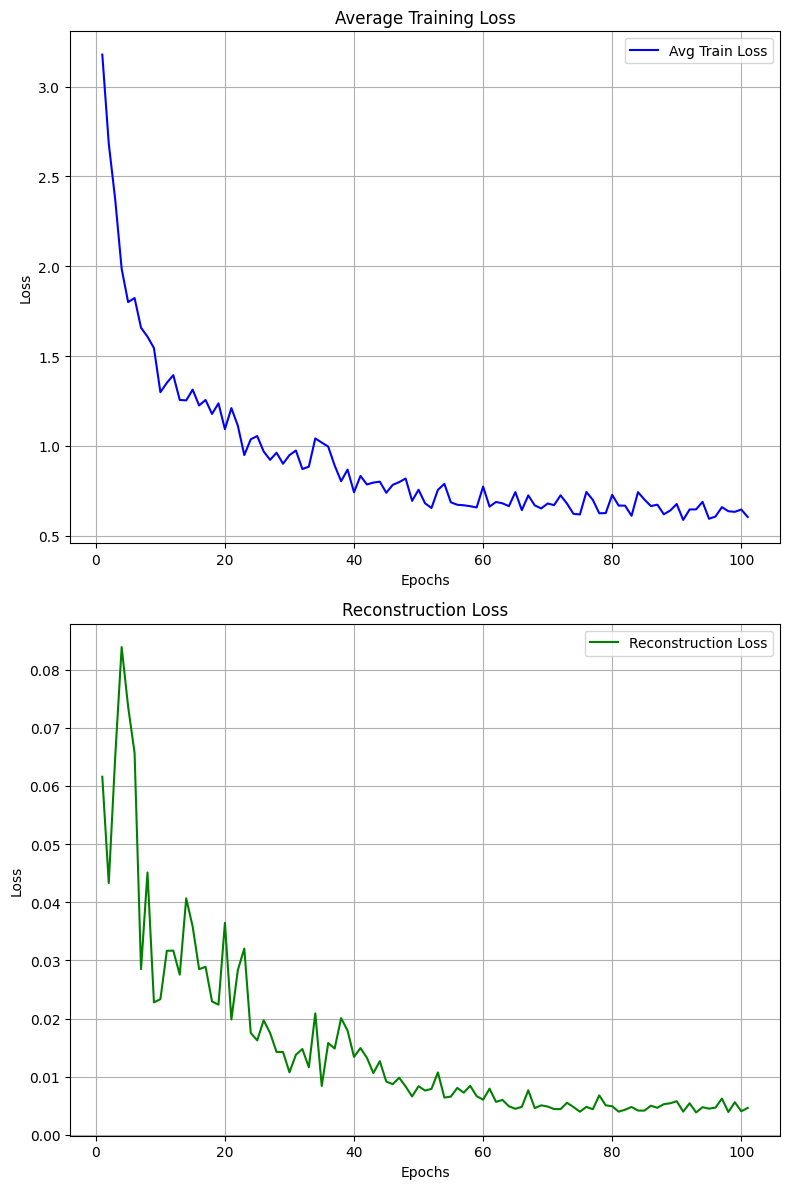

In [16]:
epochs = range(1, len(loss_history["avg_train_loss"]) + 1)

# Create three subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Plot avg_train_loss
axes[0].plot(epochs, loss_history["avg_train_loss"], label="Avg Train Loss", color="blue")
axes[0].set_title("Average Training Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)


# Plot recon_loss
axes[1].plot(epochs, loss_history["recon_loss"], label="Reconstruction Loss", color="green")
axes[1].set_title("Reconstruction Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)


plt.tight_layout()
plt.show()

# Loading Model(s)

In [17]:
# Single Model (Not Preferred - train split was not diverse covering all variety of disks)

fold_no = 1
models = []
eae = EquivariantAE()
checkpoint = torch.load("/kaggle/input/eae_light_task2/other/default/1/eae_light (1).pth")
eae.load_state_dict(checkpoint['model_state_dict'])
eae = eae.to(device)
models.append(eae)


full_test_dataset = MeraDataset(paths, transform=test_transforms)
full_test_dataloader = DataLoader(full_test_dataset, batch_size=16, shuffle=False)  

<ipython-input-17-2d1faff48c93>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/eae_light_task2/other/default/1/eae_light (1).pth")


In [21]:
#All Kfold trained models (Preferred - covers all given data buit less chance of overfitting due to average voting)

# Using models trained previously on General Test 
models = []
for fold in range(1, 11):
    model = EquivariantAE()
    model.load_state_dict(torch.load(base_path+f"/EXXA-models&data/eae_fold_{fold}.pth")['model_state_dict'])
    model = model.to(device)
    models.append(model)



full_test_dataset = MeraDataset(paths, transform=test_transforms)
full_test_dataloader = DataLoader(full_test_dataset, batch_size=16, shuffle=False)  

<ipython-input-21-f09a26185011>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(base_path+f"/EXXA-models&data/eae_fold_{fold}.pth")['model_

In [22]:
def ensemble_forward(x,models=models):
    recons = []
    latents = []
    
    for model in models :
        with torch.no_grad():
            x_recon, z1 = model(x)
            recons.append(x_recon)
            latents.append(z1)
    
    mean_recon = torch.mean(torch.stack(recons), dim=0)
    mean_latent = torch.mean(torch.stack(latents), dim=0)
    return mean_recon, mean_latent


# Resconstructing

In [23]:
images = []
all_recons = []
all_latents = []
with torch.no_grad():
    for x in full_train_dataloader:
        x = x.to(device)
        ensemble_recons,ensemble_latent  = ensemble_forward(x)
        all_recons.append(ensemble_recons.cpu().numpy())
        images.append(x.cpu().numpy())
        ensemble_latent = ensemble_latent.view(ensemble_latent.shape[0], -1)
        all_latents.append(ensemble_latent.cpu().numpy())

latent_vectors = np.concatenate(all_latents, axis=0)
images = np.concatenate(images, axis=0)
all_recons = np.concatenate(all_recons, axis=0)

mse_values = np.mean((images - all_recons) ** 2, axis=(1, 2, 3))  

print(f"Mean MSE: {np.mean(mse_values):.6f}")

Mean MSE: 0.043749


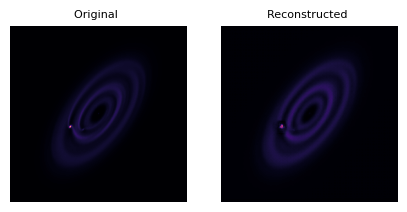

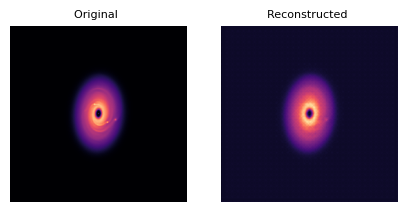

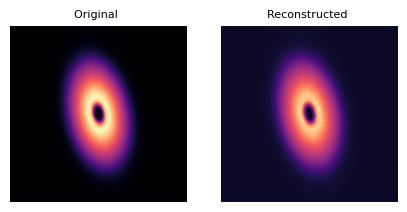

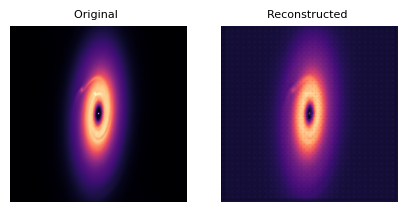

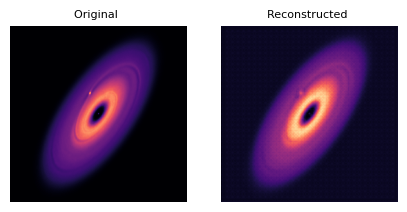

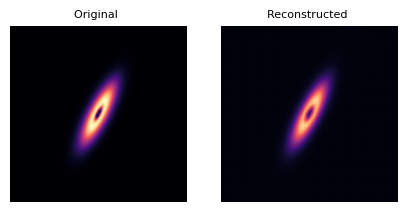

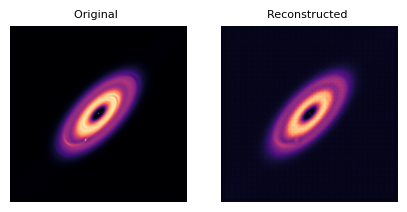

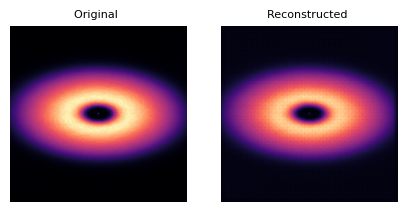

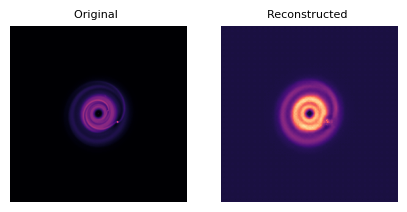

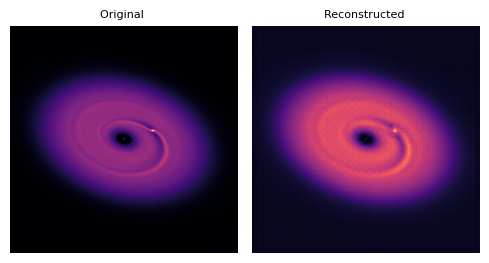

In [26]:

for j in range(30,40):
    fig, axes = plt.subplots(1,2, figsize=(5, 3))
    axes[0].imshow(images[j][0], cmap="magma")
    axes[0].set_title(f"Original ", fontsize=8)
    axes[0].axis("off")
    axes[1].imshow(all_recons[j][0], cmap="magma")
    axes[1].set_title(f"Reconstructed ", fontsize=8)
    axes[1].axis("off")
    

plt.tight_layout()
plt.show()

In [29]:
#Checking invaraint nature of the architecture wrt below transformations

e2trans_shear = transforms.Compose([
    transforms.Pad(padding=414, padding_mode="edge"),
    transforms.RandomChoice([
        transforms.RandomAffine(degrees=180,scale=(0.2,1),shear=(20, 50)),
        transforms.RandomAffine(degrees=180,scale=(0.2,1),shear=(-50, -20))]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.CenterCrop((256, 256)),
])

index = 1

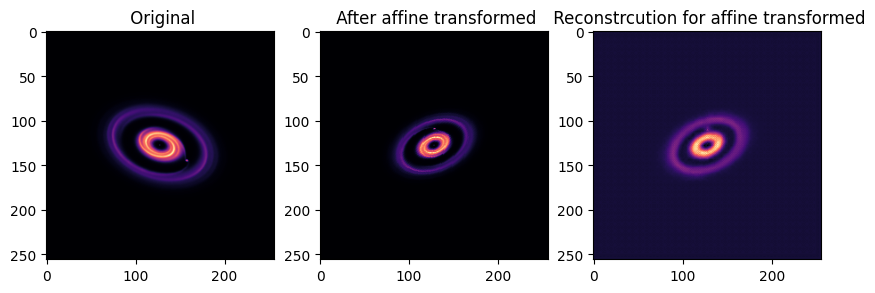

In [30]:
img = torch.tensor(images[index])
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title(f" Original")
plt.imshow(img[0],cmap='magma')


transformed = e2trans_shear(img)
plt.subplot(1,3,2)
with torch.no_grad():
    transformed_recons,_ = ensemble_forward(transformed.to(device).unsqueeze(0))
plt.title(f" After affine transformed")
plt.imshow(transformed[0],cmap='magma')
plt.subplot(1,3,3)
plt.title(f" Reconstrcution for affine transformed")
plt.imshow(transformed_recons[0][0].cpu().numpy(),cmap='magma')


# Testing

In [31]:
path_to_your_image = "/kaggle/working/continuum_data_subset/planet0_00226_1250.fits"


with fits.open(path_to_your_image) as hdul:
    image = hdul[0].data[0][0][0]
    image = normalise(image)
    
x = test_transforms(image)

recons,latent = ensemble_forward(x.unsqueeze(0).to(device))

latent = latent.view(recons.shape[0], -1).cpu()
recons = recons.cpu()
